In [1]:
import numpy as np
from numba import cuda, uint16, float64, int16
from collections import Counter
import time

### Synthetic data

In [2]:
listsizes = [20,60,120,160,200]
args_list = list()
for ls in listsizes:
    x = list(np.random.randint(0,400,ls))
    y = list(np.random.randint(0,200,ls))
    m = len(x)
    n = len(y)
    z = x + y;z.sort()
    S = sum(z[m:])
    dtype = np.uint16
    args_list.append([m,n,S,z,dtype])


### Mimic R's "table(factor(x, y))" function

In [3]:
def table(val, S):
    table = np.zeros(S + 1)
    for e in val:
        table[e] +=1
    return table

### Shift-function 

In [4]:
def shift(v, i): return np.pad(v[0:len(v) - i], (i,0), 'constant')

# Exact permutation test with the shift-method

In [5]:
def exact_perm_shift(m, n, S, z, dtype):
    N = np.zeros([S + 1, m + n, m], dtype)
    for k in range(1,(m+n)+1):
        N[:,k -1,0] = table(z[0:k],S)
    
    for k in range(2,(m+n)+1):
        for j in range(2, m +1):
            N[:,k-1,j-1] = shift(N[:,k-2,j-2], z[k -1]) + N[:,k-2,j-1]
    return N

### A function that calculates the permutations of the sub-array on the GPU

In [6]:
@cuda.jit("(u2[:,:,:], u2, u2)")
def get_perumations(X, k_, z_):
    n = X.shape[0]
    m = X.shape[2]
    
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    if j >= 2 and j < m + 1 and  i < n :
        if i >= int(z_):
            X[i, k_- 1, j-1] = X[i - int(z_), k_-2 ,j-2] +  X[i,k_-2,j-1]
        else:
            X[i, k_-1, j-1] = X[i,k_-2, j-1]

# Exact permutation test with a parallelized(on the GPU) version of the shift-method

In [7]:
def exact_perm_numba_shift(m, n, S, z, dtype):
    N_cuda = np.zeros([S + 1, m + n, m], dtype)
    NN, NM = N_cuda[:,0,:].shape

    for k in range(1,(m+n)+1):
        N_cuda[:,k -1,0] = table(z[0:k],S )
    
    A = N_cuda.copy()
    blockdim = (256, 3)
    griddim = (int(np.ceil((NN )/ blockdim[0])), int(np.ceil(NM/blockdim[1] + 1)))
    A = np.ascontiguousarray(A) 
    stream = cuda.stream()
    dA = cuda.to_device(A, stream)
    
    for k in range(2, (m+n)+1):
        dk = np.uint16(k) 
        dz = np.uint16(z[k - 1])
        get_perumations[griddim,blockdim, stream](dA, dk, dz)
    dA.to_host(stream)
    stream.synchronize()
    return A


In [8]:
plain_shift = list()
gpu_shift = list()
for args in args_list:
    start = time.time()
    N = exact_perm_shift(*args)
    end = time.time()
    plain_shift.append(round(end - start,3))
    print("Plain")
    print(round(end - start,3))
    
    start = time.time()
    A = exact_perm_numba_shift(*args)
    end = time.time()
    gpu_shift.append(round(end - start,3))
    print("GPU")
    print(round(end - start,3))
    
    print(np.allclose(A[:,:,-1], N[:,:,-1]))
    
    

Plain
0.037
GPU
0.03
True
Plain
1.396
GPU
0.154
True
Plain
21.636
GPU
1.385
True
Plain
56.068
GPU
3.223
True
Plain
132.244
GPU
6.436
True


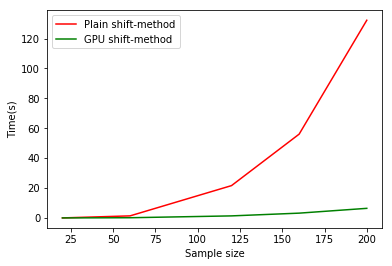

In [10]:
import matplotlib.pyplot as plt

plt.plot(listsizes, plain_shift, 'r-', label='Plain shift-method')
plt.plot(listsizes, gpu_shift, 'g-', label='GPU shift-method')
plt.legend(loc='upper left')
plt.xlabel("Sample size")
plt.ylabel("Time(s)")
plt.show()